In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# 加载数据
data = pd.read_feather('features1.feather')
# X = data.iloc[:, 1:103]  # x1 ~ x100
# y = data['y1']  # 目标变量 y2# 划分训练集和测试集
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

皮尔森相关系数

In [ ]:
# 计算皮尔森相关系数
correlation_matrix = data.corr()
# 输出y3与各个特征的相关性
print(correlation_matrix['y3'].sort_values(ascending=False))

使用XGBoost Regression

In [2]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

X = data.drop(columns=['y3'])  # 特征集
y = data['y3']  # 目标变量

regressor = xgb.XGBRegressor(eval_metric='rmsle', tree_method='gpu_hist')
# set up our search grid
param_grid = {
    "max_depth": [4, 5, 6],
    "n_estimators": [500, 600, 700],
    "learning_rate": [0.01, 0.015]
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
search = GridSearchCV(regressor, param_grid, cv=5).fit(X_train, y_train)
print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'learning_rate': 0.015, 'max_depth': 6, 'n_estimators': 700}


In [22]:
# regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
#                            n_estimators  = search.best_params_["n_estimators"],
#                            max_depth     = search.best_params_["max_depth"],
#                            eval_metric='rmsle')
regressor=xgb.XGBRegressor(learning_rate = 0.015,
                           n_estimators  = 800,
                           max_depth     = 7,
                           eval_metric='rmsle')
regressor.fit(X_train, y_train)
predictions = regressor.predict(X_test)

In [23]:
from sklearn.metrics import mean_squared_error
mse = np.sqrt( mean_squared_error(y_test, predictions))
print("The score is %.5f" % mse )

The score is 0.00030


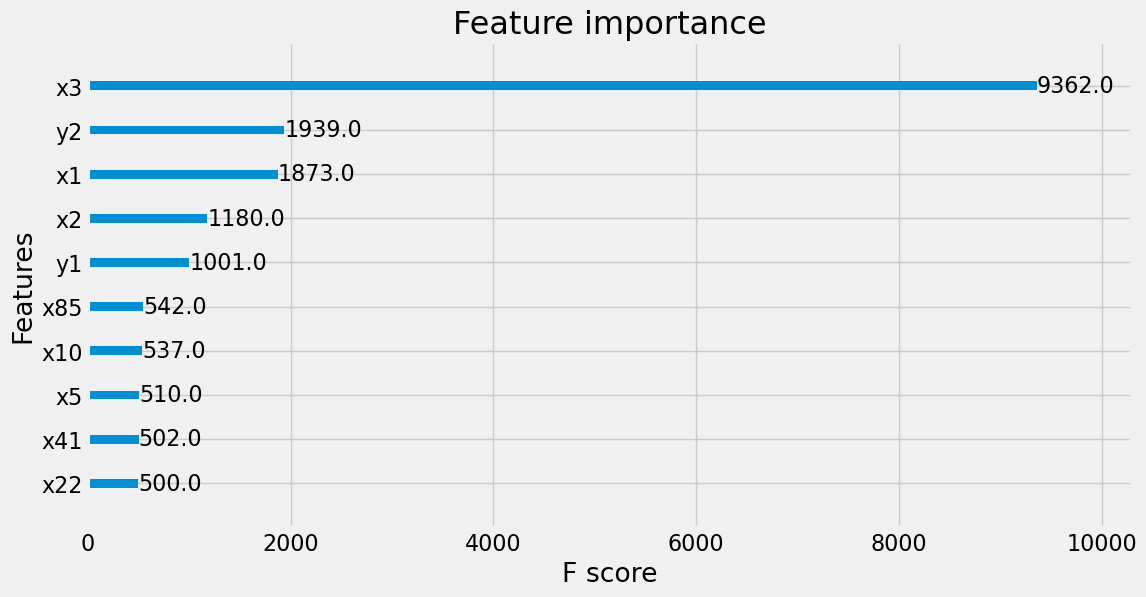

In [24]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(regressor, max_num_features=10, ax=ax)
plt.show();

In [29]:
# 获取特征的重要性
importances = regressor.feature_importances_

# 获取特征名称
feature_names = X_train.columns

# 按照重要性排序，选择前10个特征
indices = np.argsort(importances)[-10:]
top_10_features = feature_names[indices]

print("Top 10 important features:", top_10_features)


Top 10 important features: Index(['x5', 'x19', 'x22', 'x83', 'x97', 'x49', 'x34', 'x3', 'x36', 'x2'], dtype='object')


使用前10个特征训练新模型

In [30]:
# 仅保留前10个重要特征
X_train_top10 = X_train[top_10_features]
X_test_top10 = X_test[top_10_features]

# 训练新的XGBoost模型
regressor_top10 = xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                                   n_estimators  = search.best_params_["n_estimators"],
                                   max_depth     = search.best_params_["max_depth"],
                                   eval_metric='rmsle')

regressor_top10.fit(X_train_top10, y_train)

# 使用新模型对测试集进行预测
predictions_Y = regressor_top10.predict(X_test_top10)

# 计算新模型在测试集上的均方误差
mse_top10 = np.sqrt(mean_squared_error(y_test, predictions_Y))
print("The score with top 10 features is %.5f" % mse_top10)

The score with top 10 features is 0.00030


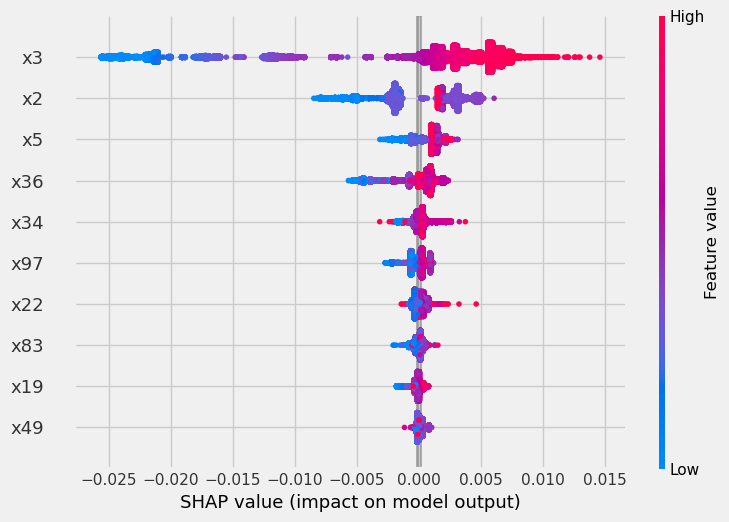

In [31]:
import shap

# 计算 SHAP 值
explainer = shap.TreeExplainer(regressor_top10)
shap_values = explainer.shap_values(X_test_top10)

# 绘制 SHAP 图
shap.summary_plot(shap_values, X_test_top10)

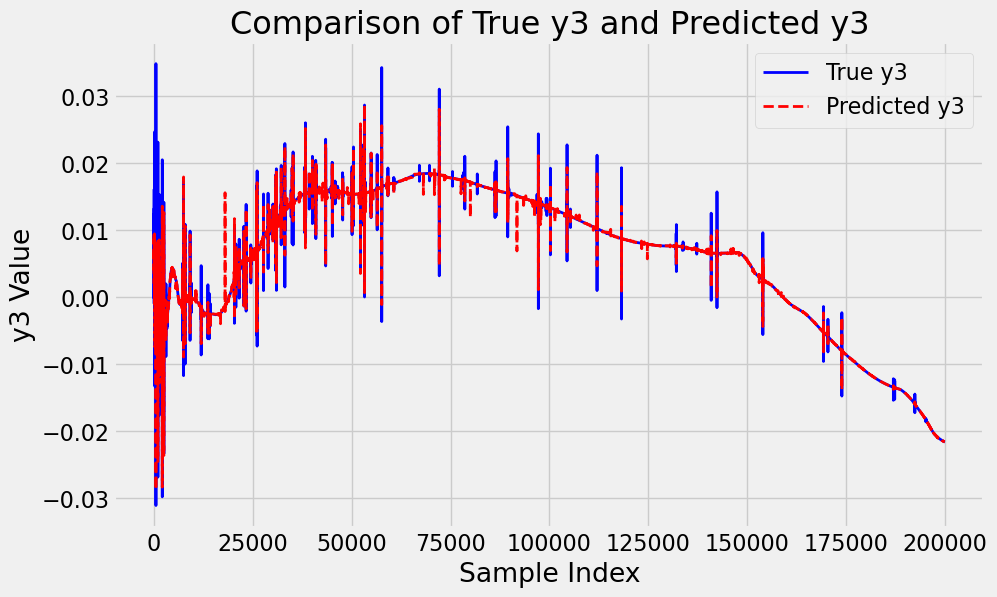

In [32]:
X_top10 = X[top_10_features]
y_pred_top10 = regressor_top10.predict(X_top10)
plt.figure(figsize=(10, 6))
plt.plot(y, label="True y3", color="blue", linewidth=2)

plt.plot(y_pred_top10, label="Predicted y3", color="red", linestyle="--", linewidth=2)
plt.legend()
plt.title("Comparison of True y3 and Predicted y3")
plt.xlabel("Sample Index")
plt.ylabel("y3 Value")
plt.show()

In [33]:
mse1 = mean_squared_error(y,y_pred_top10)
print(f"使用前10个特征的预测结果的均方误差: {mse1}")

使用前10个特征的预测结果的均方误差: 4.042165359887524e-08
